<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/heba/datawhisperers_sentiment_analysis_amazon_apparel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce | Apparel
---



<b>Objectives</b>
- Product owner's perspective: 
  - Quality improvement |
  - Gap analysis | same product different maker?
  - Reputation management
- Investor's perspective: 
  - which product owners improve over time
- Consumer perspective
  - Influencial posts

- ML Practice | Inferrential analysis for positive or negative feedback on products in social media product  


---
Notes: 
* #todo : means to check or come back to the code

<b>Understanding the Dataset</b>

* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier (can be used to aggregatereviews for the same product).
*product_title     : Title of the product.
*product_category  : Broad product category.
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

https://www.tensorflow.org/datasets/catalog/amazon_us_reviews

#### Importing libaries and Apparel dataset

In [2]:
# (1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [3]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  68.5M      0  0:00:09  0:00:09 --:--:-- 76.8M


In [4]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

In [5]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv  sample_data


In [6]:
# (3.b) Explore data (see what is categorial and numerical)

In [7]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=300000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        300000 non-null  object
 1   customer_id        300000 non-null  int64 
 2   review_id          300000 non-null  object
 3   product_id         300000 non-null  object
 4   product_parent     300000 non-null  int64 
 5   product_title      300000 non-null  object
 6   product_category   300000 non-null  object
 7   star_rating        300000 non-null  int64 
 8   helpful_votes      300000 non-null  int64 
 9   total_votes        300000 non-null  int64 
 10  vine               300000 non-null  object
 11  verified_purchase  300000 non-null  object
 12  review_headline    299999 non-null  object
 13  review_body        299858 non-null  object
 14  review_date        299997 non-null  object
dtypes: int64(5), object(10)
memory usage: 34.3+ MB


In [8]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
299995,US,11794308,RGL12VWDODBGF,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,They would be a decent pair of scrubs for the ...,They would be a decent pair of scrubs for the ...,2015-08-02
299996,US,10525470,R1D9YUDSAF43Z9,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,2,2,N,Y,Fit?,I want to start by saying I love the style. Th...,2015-06-08
299997,US,11785074,R38HJNAO7LK722,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,1,1,1,N,Y,One Star,"They were too small, and it was difficult to r...",2015-05-12
299998,US,24098870,R3TT5VMKGA7MG6,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,4,0,0,N,Y,For the price these scrubs are great! The top ...,For the price these scrubs are great! The top ...,2015-08-31
299999,US,19988435,R1V5G2V0O5QXDT,B00RNT940S,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,Three Stars,good quality but it's quite large for me,2015-08-26


###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [9]:
# Checking unique values of each row in all columns
n = df.nunique(axis=0)
print(
    "Total number of rows in this data set is:{}\nNumber of unique values in each column for in this dataset is:\n"
    .format(len(df)), n)
# outcome --> drop marketplace-category-reviewID
# outcome --> bool vine verified purchase

Total number of rows in this data set is:300000
Number of unique values in each column for in this dataset is:
 marketplace               1
customer_id          241149
review_id            300000
product_id           182913
product_parent       103541
product_title        100013
product_category          1
star_rating               5
helpful_votes           277
total_votes             293
vine                      2
verified_purchase         2
review_headline      143469
review_body          270057
review_date             271
dtype: int64


In [10]:
# Cleaning
# (1) Drop irrelevant info: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])
 
# (4) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

# (5) Drop the rows where there are no reviews and no review dates
df.dropna(subset = ['review_body'], inplace = True)
df.dropna(subset = ['review_date'], inplace = True)

#  creating numerical df -> df_num for EDA
#  creating categorical df -> df_cat
cat_list = ['product_parent','product_id','customer_id','product_title','review_body']

df_num = df.drop(cat_list, inplace = False , axis = 1) 
df_cat = df[cat_list]

# Print to see the null rows if any
null_columns=df.columns[df.isnull().any()]
df[df["review_date"].isnull()] #[null_columns] add to tail end to show null columns when that particular colum is null

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date


In [11]:
df.info()
df_cat.info() 
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299854 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        299854 non-null  int64         
 1   product_id         299854 non-null  object        
 2   product_parent     299854 non-null  int64         
 3   product_title      299854 non-null  object        
 4   star_rating        299854 non-null  int64         
 5   helpful_votes      299854 non-null  int64         
 6   total_votes        299854 non-null  int64         
 7   vine               299854 non-null  int64         
 8   verified_purchase  299854 non-null  int64         
 9   review_body        299854 non-null  object        
 10  review_date        299854 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 27.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299854 entries, 0 to 299999
Data columns 

#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e

In [12]:
print(df['review_body'])

0         ★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...
1         Favorite for winter. Very warm! I love this dr...
2         Great Socks for the money. Nice socks, great c...
3         Slick hat! I bought this for my husband and WO...
4         I would do it again! Perfect dress and the cus...
                                ...                        
299995    They would be a decent pair of scrubs for the ...
299996    Fit? I want to start by saying I love the styl...
299997    One Star They were too small, and it was diffi...
299998    For the price these scrubs are great! The top ...
299999    Three Stars good quality but it's quite large ...
Name: review_body, Length: 299854, dtype: object


In [13]:
# Removing the hashtags | Revise - not working #todo
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)


In [14]:
# Removing the emojis |

# # Reference code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# def remove_emoji(review_body):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

In [15]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [16]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
# df['review_body'] = df['review_body'].values.tolist()
df['review_body']

0         ★ these really do work great with some tweakin...
1         favorite for winter. very warm! i love this dr...
2         great socks for the money. nice socks, great c...
3         slick hat! i bought this for my husband and wo...
4         i would do it again! perfect dress and the cus...
                                ...                        
299995    they would be a decent pair of scrubs for the ...
299996    fit? i want to start by saying i love the styl...
299997    one star they were too small, and it was diffi...
299998    for the price these scrubs are great! the top ...
299999    three stars good quality but it's quite large ...
Name: review_body, Length: 299854, dtype: object

In [17]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_numbers(row['review_body']), axis=1)


In [18]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df.apply(lambda row: remove_non_ascii(row['review_body']), axis=1)

In [19]:
# Removal of punctuation
import re      # Import REGEX
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_punctuation(row['review_body']), axis=1)


In [20]:
# Import nltk stop words
# # Removal of stop words
import nltk
from nltk.corpus import stopwords            #Stopwords corpus
stopwords = stopwords.words('english')

In [21]:
# Customising the stop words - we need to review this #todo
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# # Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

In [22]:
# after cleaning text, bring the words into a list
df['review_body'] = df.apply(lambda row: nltk.word_tokenize(row['review_body']), axis=1)
df['review_body']

0         [these, really, do, work, great, with, some, t...
1         [favorite, for, winter, very, warm, i, love, t...
2         [great, socks, for, the, money, nice, socks, g...
3         [slick, hat, i, bought, this, for, my, husband...
4         [i, would, do, it, again, perfect, dress, and,...
                                ...                        
299995    [they, would, be, a, decent, pair, of, scrubs,...
299996    [fit, i, want, to, start, by, saying, i, love,...
299997    [one, star, they, were, too, small, and, it, w...
299998    [for, the, price, these, scrubs, are, great, t...
299999    [three, stars, good, quality, but, its, quite,...
Name: review_body, Length: 299854, dtype: object

### EDA and Feature Engineering

In [24]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id', 'product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

df_num.describe()

,star_rating,helpful_votes,total_votes,vine,verified_purchase
count,299854.000000,299854.000000,299854.000000,299854.000000,299854.000000
mean,3.980694,1.289301,1.528801,0.002294,0.917520
std,1.361413,11.471966,11.939118,0.047846,0.275095
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,1.000000,1.000000,0.000000,1.000000
max,5.000000,3675.000000,3714.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


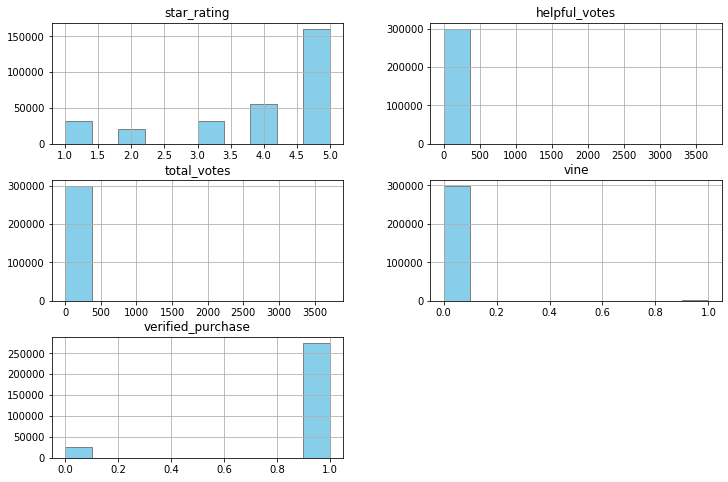

In [25]:
# Check the distribution of the star rating with the DataFrame | reference chart: https://www.datacamp.com/community/tutorials/histograms-matplotlib
# plt.hist(df.star_rating, bins='auto', color = "skyblue", ec='grey')
# plt.gca().set(title='Frequency Histogram | Review Stars |', ylabel='Frequency',xlabel = 'stars',alpha=0.7, rwidth=0.85);
# plt.show()

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df_discriptive.hist(ax=ax, color = "skyblue", ec='grey')
plt.show()

# Clustering per groups of product parent | votes per product parent
# Sentimet (from -ve) most common words for improvement | from (+ve) most common words for gap analysis
# we will need to scale our stars to min max
# then our scaled stars are our sentiment label, and text is the features? 


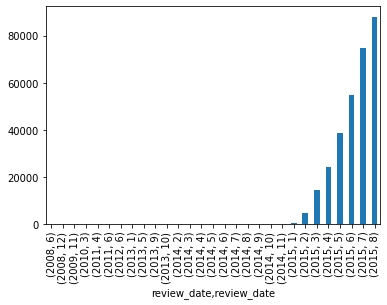

In [28]:
# Looking at year and month for review | seems we can extra clean outliers outside 2015 #todo
df.star_rating.groupby([df["review_date"].dt.year, df["review_date"].dt.month]).count().plot(kind="bar")

In [26]:
# Looking at product parent | 
df.product_id.groupby([df["product_parent"],df['star_rating']]).count().plot(kind="bar")

KeyboardInterrupt: ignored

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7ff4801d30e0> (for post_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py", line 28, in trigger
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/display.py", line 306, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py", line 173, in format
    data = formatter(obj)
  File "<decorator-gen-2>", line 2, in __call__
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py", line 217, in catch_format_error
    r = method(

KeyboardInterrupt: ignored

In [ ]:
# (4) Choose the label and features

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

In [ ]:
# (6) Confirm data is ready with further exploratory analysis

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [ ]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [ ]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [ ]:
# (11) Use the model for prediction

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)